# NSCI 290 Final Project: ABIDE Preprocessed Autism Database Study

## Data Analysis

### Test Code for One Subject

In [2]:
from nilearn import datasets, image, input_data
import numpy as np

# Load Schaefer atlas (200 parcels)
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7)
atlas_img = schaefer['maps']
labels = schaefer['labels']

C:\Users\arryn\AppData\Local\Temp\ipykernel_28276\1339449442.py:1: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn import datasets, image, input_data


[fetch_atlas_schaefer_2018] Dataset found in C:\Users\arryn\nilearn_data\schaefer_2018


In [3]:
# finding data
data_folder = "func_preproc_css_filt_global"

# adding masks
masker = input_data.NiftiLabelsMasker(labels_img=atlas_img, standardize=True)
fmri_img = data_folder + "\Outputs\ccs\\filt_global\\func_preproc\Leuven_1_0050689_func_preproc.nii.gz"
time_series = masker.fit_transform(fmri_img)  # shape: (timepoints, ROIs)

<>:6: SyntaxWarning: invalid escape sequence '\O'
<>:6: SyntaxWarning: invalid escape sequence '\O'
C:\Users\arryn\AppData\Local\Temp\ipykernel_28276\3021727528.py:6: SyntaxWarning: invalid escape sequence '\O'
  fmri_img = data_folder + "\Outputs\ccs\\filt_global\\func_preproc\Leuven_1_0050689_func_preproc.nii.gz"


In [4]:
import nibabel as nib

def get_img_tr(img_path):

    # load the NIfTI image
    img = nib.load(img_path)

    # get TR (repetition time)
    TR = img.header.get_zooms()[3]  # 4th dimension = time

    return TR

TR = get_img_tr(fmri_img)
print(TR)

1.6667


In [5]:
def sliding_window_fc(time_series, window_size=30, step=1):
    n_timepoints, n_rois = time_series.shape
    n_windows = (n_timepoints - window_size) // step + 1
    fc_matrices = []

    for i in range(0, n_windows * step, step):
        window_ts = time_series[i:i+window_size, :]
        corr_matrix = np.corrcoef(window_ts.T)  # ROI x ROI correlation
        fc_matrices.append(corr_matrix)
    
    return np.array(fc_matrices)  # shape: (n_windows, n_rois, n_rois)

# Example: 30 TR window, step 1
fc_matrices = sliding_window_fc(time_series, window_size=30, step=1)
print(fc_matrices.shape)  # e.g., (170, 200, 200)

(216, 200, 200)


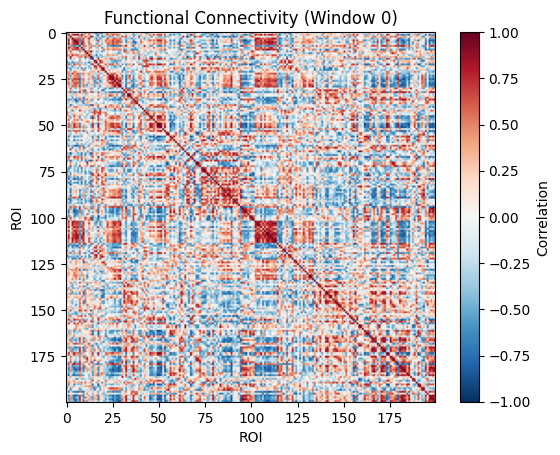

In [6]:
import matplotlib.pyplot as plt

# pick a window
fc = fc_matrices[0]

# display heatmap
plt.imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title("Functional Connectivity (Window 0)")
plt.xlabel("ROI")
plt.ylabel("ROI")
plt.show()

In [7]:
# Variability across time for each ROI pair
fc_std = np.std(fc_matrices, axis=0)  # ROI x ROI
print(fc_std)

[[9.09635404e-17 2.69494257e-01 3.03009928e-01 ... 3.28656923e-01
  2.61444720e-01 2.62783392e-01]
 [2.69494257e-01 9.52537136e-17 3.43314237e-01 ... 2.68130688e-01
  1.58456548e-01 2.19910198e-01]
 [3.03009928e-01 3.43314237e-01 7.74066021e-17 ... 4.16895906e-01
  4.10129521e-01 3.66029980e-01]
 ...
 [3.28656923e-01 2.68130688e-01 4.16895906e-01 ... 8.24056207e-17
  1.94657193e-01 1.65285133e-01]
 [2.61444720e-01 1.58456548e-01 4.10129521e-01 ... 1.94657193e-01
  6.49829188e-17 1.90675432e-01]
 [2.62783392e-01 2.19910198e-01 3.66029980e-01 ... 1.65285133e-01
  1.90675432e-01 9.34391910e-17]]


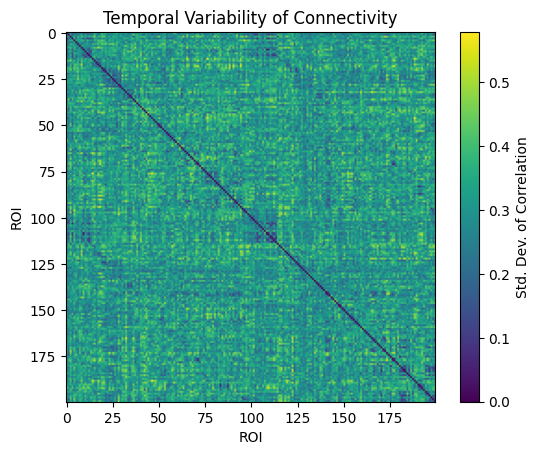

In [8]:
# displaying FC STD heatmap
plt.imshow(fc_std, cmap='viridis')
plt.colorbar(label='Std. Dev. of Correlation')
plt.title("Temporal Variability of Connectivity")
plt.xlabel("ROI")
plt.ylabel("ROI")
plt.show()

### Code for All Subjects
#### Calculating Portion of Time to Use

In [9]:
import nibabel as nib
from pathlib import Path

data_folder = Path("func_preproc_css_filt_global\Outputs\ccs\\filt_global\\func_preproc")
min_duration = None

for f in data_folder.iterdir():
    if f.is_file() and ".nii" in f.suffixes:
        img = nib.load(str(f))
        header = img.header

        n_vols = img.shape[3] # number of timepoints
        tr = header.get_zooms()[3] # TR in seconds

        total_duration = n_vols * tr

        if min_duration == None or total_duration < min_duration:
            min_duration = total_duration
        
        #print(total_duration)

print("Min Duration:")
print(min_duration)

# calculating analysis duration
duration = min_duration * 0.5
print("Analysis Duration:")
print(duration)

<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\O'
C:\Users\arryn\AppData\Local\Temp\ipykernel_28276\2484691023.py:4: SyntaxWarning: invalid escape sequence '\O'
  data_folder = Path("func_preproc_css_filt_global\Outputs\ccs\\filt_global\\func_preproc")


Min Duration:
145.0
Analysis Duration:
72.5


#### Applying Atlas & Calculating Metrics

In [10]:
from nilearn import datasets, image, input_data
import numpy as np

# load schaefer atlas
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200)
atlas_img = schaefer['maps']
labels = schaefer['labels']

[fetch_atlas_schaefer_2018] Dataset found in C:\Users\arryn\nilearn_data\schaefer_2018


In [ ]:
# finding and preparing data (do once and then use the blocks below to save/load it)
# time_series_map = {}
# masker = input_data.NiftiLabelsMasker(labels_img=atlas_img, standardize=True)

# for f in data_folder.iterdir():
#     if f.is_file() and ".nii" in f.suffixes:
#         print(f)
        
#         # adding masks
#         fmri_img = f.as_posix()
#         time_series = masker.fit_transform(fmri_img)  # shape: (timepoints, ROIs)

#         # only including middle 72.5 seconds
#         tr = get_img_tr(str(f))
#         frame_count = int(round(duration / tr))

#         n = time_series.shape[0]
#         start = (n - frame_count) // 2
#         end = start + frame_count

#         time_series = time_series[start:end]

#         # inserting timeseries data
#         time_series_map[str(f)] = time_series

func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051456_func_preproc.nii.gz
func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051457_func_preproc.nii.gz
func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051458_func_preproc.nii.gz
func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051459_func_preproc.nii.gz
func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051460_func_preproc.nii.gz
func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051461_func_preproc.nii.gz
func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051462_func_preproc.nii.gz
func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051463_func_preproc.nii.gz
func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051464_func_preproc.nii.gz
func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051465_

In [ ]:
## Use this to save the processed data from above into a json file

# import json

# # creating serializable copy of data
# serializable = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in time_series_map.items()}

# # saving processed fMRI data as file
# with open("time_series_map.json", "w") as f:
#     json.dump(serializable, f, indent=4)

In [ ]:
## use this to laod the processed data back into a dictionary

import json
import numpy as np

with open("time_series_map.json") as f:
    loaded = json.load(f)

time_series_map = {
    k: np.array(v) if isinstance(v, list) else v for k, v in loaded.items()
}

In [45]:
# verifying correct sizes after splicing middle 72.5 seconds
for path_str in time_series_map:
    print("Path: " + str(path_str))
    time_series = time_series_map[path_str]
    print(time_series.shape)

Path: func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051456_func_preproc.nii.gz
(36, 200)
Path: func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051457_func_preproc.nii.gz
(36, 200)
Path: func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051458_func_preproc.nii.gz
(36, 200)
Path: func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051459_func_preproc.nii.gz
(36, 200)
Path: func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051460_func_preproc.nii.gz
(36, 200)
Path: func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051461_func_preproc.nii.gz
(36, 200)
Path: func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051462_func_preproc.nii.gz
(36, 200)
Path: func_preproc_css_filt_global\Outputs\ccs\filt_global\func_preproc\Caltech_0051463_func_preproc.nii.gz
(36, 200)
Path: func_preproc_css_filt_global\Outputs\ccs\filt_glob

In [46]:
limbic_indices = []
somamotor_indices = []
visual_indices = []

for i, label in enumerate(labels):
    if "Vis" in label:
        visual_indices.append(i)
    if "SomMot" in label:
        somamotor_indices.append(i)
    if "Limbic" in label:
        limbic_indices.append(i)

print(limbic_indices)
print(somamotor_indices)
print(visual_indices)

[55, 56, 57, 58, 59, 60, 159, 160, 161, 162, 163, 164]
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]


In [65]:
import math

# get the average correlation STD from on ROI compared to a list of others
def compare_roi_with_others(fc_std: list[list[float]], roi: int, others: list[int]) -> float:
    mean_std = 0
    count = 0
    for other in others:
        if fc_std.ndim == 2:
            std = fc_std[roi][other]
            if not math.isnan(std):
                mean_std += std
                count += 1
            # else:
            #     print(f"Issue when comparing ROI {roi} and ROI {other}: STD result was NAN. Not counting towards mean.")
        # else:
        #     print(f"Issue when comparing ROI {roi} and ROI {other}: missing data. Not counting towards mean.")

    if count == 0:
        return math.nan
    
    mean_std /= count
    return mean_std

# get average connectivity within larger region made up of multiple ROIs
def roi_inter_std_mean(fc_std: list[list[float]], region_indices: list[int]) -> float:
    overall_mean = 0
    count = 0
    for roi in region_indices:
        others = region_indices.copy()
        others.remove(roi)
        
        roi_mean = compare_roi_with_others(fc_std, roi, others)
        if not math.isnan(roi_mean):
            overall_mean += roi_mean
            count += 1

    if count == 0:
        return math.nan

    overall_mean /= count
    return overall_mean
    

In [51]:
import pandas as pd

def is_patient(file_name: str) -> bool:
    pt_data = pd.read_csv("Phenotypic_V1_0b_preprocessed1.csv")
    file_id = file_name.removesuffix("_func_preproc.nii.gz")
    row = pt_data[pt_data['FILE_ID'] == file_id]

    if not row.empty:
        diag = int(row['DX_GROUP'])
        if diag == 1:
            return True
        
    return False

In [ ]:
import os

patient_avgs = {
    "limbic_avg" : 0,
    "limbic_count" : 0,
    "somamotor_avg" : 0,
    "somamotor_count" : 0,
    "visual_avg" : 0,
    "visual_count" : 0
}
control_avgs = {
    "limbic_avg" : 0,
    "limbic_count" : 0,
    "somamotor_avg" : 0,
    "somamotor_count" : 0,
    "visual_avg" : 0,
    "visual_count" : 0
}

patient_data = {} # file name mapped with a dictionary of std means for each network
control_data = {}

limbic_values = {
    "patient" : [],
    "control" : []
}
somamotor_values = {
    "patient" : [],
    "control" : []
}
visual_values = {
    "patient" : [],
    "control" : []
}


for path_str in time_series_map:
    time_series = time_series_map[path_str]

    # conducting sliding window technique
    fc_matrices = sliding_window_fc(time_series, window_size=10)

    # Variability across time for each ROI pair
    fc_std = np.std(fc_matrices, axis=0)  # ROI x ROI

    # calculating inter-region STD means
    means = {
        "limbic" : roi_inter_std_mean(fc_std, limbic_indices),
        "somamotor" : roi_inter_std_mean(fc_std, somamotor_indices),
        "visual" : roi_inter_std_mean(fc_std, visual_indices)
    }

    #print(f"limbic: {limbic_std_mean}, soma: {soma_std_mean}, visual: {visual_std_mean}")

    # determing patient/control
    file_name = os.path.basename(path_str)
    patient_flag = is_patient(file_name)
    group_name = "patient" if patient_flag else "control"
    roi_data = patient_avgs if patient_flag else control_avgs
    subject_data = patient_data if patient_flag else control_data

    # adding to ROI data
    for region in ["limbic", "somamotor", "visual"]:
        values_list = limbic_values if region == "limbic" else somamotor_values if region == "somamotor" else visual_values
        if not math.isnan(means[region]):
            
            # adding summary statistics
            roi_data[region + "_avg"] += means[region]
            roi_data[region + "_count"] += 1

            # adding patient-specific statistics
            if not file_name in patient_data:
                subject_data[file_name] = {
                    region : means[region]
                }
            else:
                subject_data[file_name][region] = means[region]

            values_list[group_name].append(means[region])

            

for region in ["limbic", "somamotor", "visual"]:
    patient_avgs[region + "_avg"] /= patient_avgs[region + "_count"]
    control_avgs[region + "_avg"] /= control_avgs[region + "_count"]

print("patients:", patient_avgs)
print("controls", control_avgs)

print("patients individual:", patient_data)
print("controls individual:", control_data)

print("limbic:", limbic_values)
print("somamotor:", somamotor_values)
print("visual:", visual_values)

#### Statistics

In [ ]:
# creating histograms
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.hist(limbic_values["control"], bins=20, alpha=0.5, label="Control")
plt.hist(limbic_values["patient"], bins=20, alpha=0.5, label="Patient")

plt.xlabel("Mean Inter-ROI STD")
plt.ylabel("Frequency")
plt.title("Histogram of Limbic Network STD Metrics")
plt.legend()
plt.show()

In [ ]:
plt.hist(visual_values["control"], bins=20, alpha=0.5, label="Control")
plt.hist(visual_values["patient"], bins=20, alpha=0.5, label="Patient")

plt.xlabel("Mean Inter-ROI STD")
plt.ylabel("Frequency")
plt.title("Histogram of Visual Network STD Metrics")
plt.legend()
plt.show()

In [ ]:
plt.hist(somamotor_values["control"], bins=20, alpha=0.5, label="Control")
plt.hist(somamotor_values["patient"], bins=20, alpha=0.5, label="Patient")

plt.xlabel("Mean Inter-ROI STD")
plt.ylabel("Frequency")
plt.title("Histogram of Somatomotor Network STD Metrics")
plt.legend()
plt.show()

In [ ]:
# running shapiro-wilk tests
import scipy.stats as stats

for data in [limbic_values, visual_values, somamotor_values]:
    print("limbic" if data == limbic_values else "visual" if data == visual_values else "somamotor")
    for group in ["patient", "control"]:
        stat, p = stats.shapiro(data[group])
        result = "reject null" if p <= 0.05 else "accept null"
        print(f"{group} - stat: {stat}, p: {p}; {result}")

In [ ]:
# testing for equality of variances
for data in [limbic_values, visual_values, somamotor_values]:
    print("limbic" if data == limbic_values else "visual" if data == visual_values else "somamotor")
    stat, p = stats.levene(data["control"], data["patient"])
    result = "reject null" if p <= 0.05 else "accept null"
    print(f"stat: {stat}, p: {p}; {result}")

In [ ]:
# mann-whitney u test for non-Normal data
for data in [limbic_values, visual_values, somamotor_values]:
    print("limbic" if data == limbic_values else "visual" if data == visual_values else "somamotor")
    stat, p = stats.mannwhitneyu(data["control"], data["patient"], alternative="two-sided")
    result = "reject null" if p <= 0.05 else "accept null"
    print(f"stat: {stat}, p: {p}; {result}")

In [ ]:
# standard t-test for Normal and equal variances
for data in [limbic_values, visual_values, somamotor_values]:
    print("limbic" if data == limbic_values else "visual" if data == visual_values else "somamotor")
    stat, p = stats.ttest_ind(data["control"], data["patient"], equal_var=True)
    print(f"stat: {stat}, p: {p}; {result}")